# CSCI-537 Final Project
# CAPTCHA Solver
### Fall 2021
### Hayden Sather, Jake Pinkston

### TO RUN: Extract the hard_data and easy_data directories to the project directory

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

import global_params as gp
import helper_funcs as hf

In [2]:
model = hf.get_model(retrain=False)

2021-12-05 23:38:05.185999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 23:38:05.189745: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-12-05 23:38:05.189760: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-05 23:38:05.189998: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [3]:


def read_captcha(img):
    img = hf.process_captcha(img)

    # Find connected components
    num_components, _, stats, centroids = cv2.connectedComponentsWithStats(img, 1, cv2.CV_8U)
    #This section gets rid of small component areas
    temp_components = 0
    temp_centroids = []
    for i in range(len(stats)):
        if stats[i][4] > gp.MIN_AREA:
            temp_components +=1
            temp_centroids.append(centroids[i])
    centroids = temp_centroids
    num_components = temp_components

    # Normalize
    img = img / 255
    img[img >= gp.PIXEL_THRESH] = 1
    img[img < gp.PIXEL_THRESH] = 0

    # plt.imshow(img_thresh, cmap=plt.get_cmap('gray'))
    # plt.show()
   
    # Comment once you want this to run fast
    # plt.imshow(img, cmap=plt.get_cmap('gray'))
    # plt.show()

    x_loc_list = []
    prediction_list = []
    for i in range(1, num_components):
        centroid = centroids[i]

        cropped_image = hf.crop_image(img, centroid)
       
        prediction = hf.img_to_prediction(cropped_image, model, verbose=False)
        if prediction is None:  # One of the images is messed up
            continue

        # Uncomment to show each individual cropped image
        # plt.imshow(cropped_image, cmap=plt.get_cmap('gray'))
        # plt.show()

        x_loc_list.append(centroid[0])
        prediction_list.append(prediction)

        prediction = hf.sort_preds(x_loc_list, prediction_list)

    return prediction

all_correct = []
all_wrong = []
agg_correct = 0
num_total = 0
for filename in os.listdir("easy_data"):
    img_path = os.path.join("easy_data", filename)
    img = cv2.imread(img_path)

    true_captcha = filename[:-4]
    true_captcha = hf.transform_string(true_captcha)
   
    predicted_captcha = read_captcha(img)
    if predicted_captcha is None:
        continue
    predicted_captcha = hf.transform_string(predicted_captcha)
   
    percent_correct = hf.similar(true_captcha, predicted_captcha)

    if percent_correct == 100:
        all_correct.append(img)
    if percent_correct == 0:
        all_wrong.append(img)

    agg_correct += percent_correct
    num_total += 1

print(f"Total Percent Correct: {agg_correct / num_total}\n")

Total Percent Correct: 73.43393277268503



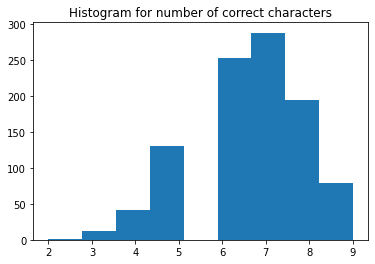

79

In [16]:
samples = np.random.binomial(9, 0.74, 1000)
plt.hist(samples, bins=9)
plt.title("Histogram for number of correct characters")
plt.show()

len(samples[samples == 9])